In [1]:
from pathlib import Path
import torch
from torch import nn
from mltools import ld,draw,models,MachineLearning

In [2]:
train_iter,val_iter,test_iter=ld.mnist('../data',batch_size=1000) # 获取训练集、验证集和测试集
rnn_layer=nn.LSTM(28, hidden_size=512, batch_first=True, bidirectional=True) # 定义循环网络LSTM
model=models.RNNModel(rnn_layer, vocab_size=28, step_size=28, output_size=10, one_hot=False) # 定义训练模型
device=torch.device('cuda')

class LSTMMNISTMachineLearning(MachineLearning):
    def calculate_y(self, x):
        x = x.squeeze(1).to(self.device)
        y, _ = self.model(x)
        return y

    def grad_update(self, loss):
        '''梯度更新'''
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
        self.optimizer.step()

ml = LSTMMNISTMachineLearning(model,train_iter,val_iter,test_iter,device=device)
model_path='../model/LSTM_MNIST.pth'

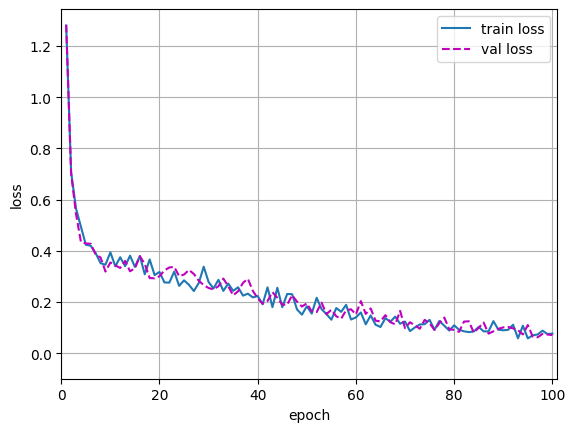

In [3]:
if True:
    ml.train(num_epochs=100,learning_rate=1e-1) # 训练
    if False:
        torch.save(model.state_dict(), model_path)
elif Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device))

In [4]:
ml.test() # 测试

Accuracy rate 0.9735999703407288


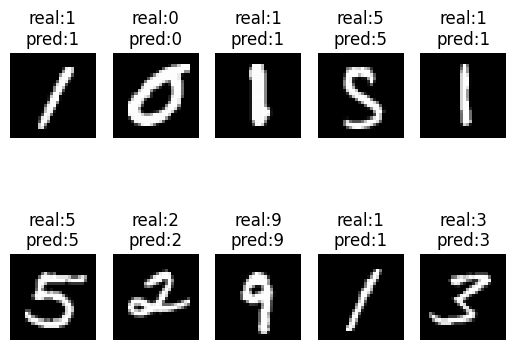

In [5]:
# 预测模型
def predict(model,test_iter,device):
    model.to(device) # 将网络复制到device上
    # 从测试中取一个批量
    x,y=next(iter(test_iter))
    x,y=x[:10].squeeze(1).to(device),y[:10].to(device)
    # 预测
    y_pred, _ = model(x)
    y_pred = y_pred.argmax(dim=1)
    labels=[f'real:{y[index]}\npred:{y_pred[index]}' for index in range(len(y))]
    # 输出样例图
    draw.images(x.unsqueeze(1),labels,shape=(2,5))
predict(model,test_iter,device)